# OpenAI CarRacing with Behavioral Cloning

In this homework, you will train an agent to drive on a race track in a video-game style simulator. The agent has a neural network controller that you will train using example data of a car racing around the track. At each timestep, the neural network takes in the *state* of the car as an image and outputs which *action* to take. 

This system is known as a *Markov Decision Process (MDP)* because at each discrete timestep, the agent makes a decision using only the current state, with no memory of the previous state (this is called Markov property). In the context of Reinforcement Learning, this training strategy is known as *behavioral cloning* because we are learning by copying the actions of another agent.

The simulator is the CarRacing-v0 environment from OpenAI. In this environment, a *state* is a (96,96,3) color image which shows the position of the car along with the current speed, stearing position, and braking status in the bottom of the image. The *actions* that are available to the agent are stear (between -1 and 1), accelerate (0 to 1), and break (0 to 1). To simplify this assignment, I have converted this into a classification problem with only seven discrete actions:

0. Do nothing
1. Left
2. Left+Break
3. Right
4. Right+Break
5. Accelerate!
6. Break

Below is provided a dataset of 11,132 example (state, action) pairs you can use for training. These were sampled from simulations of a highly-skilled AI agent. The first cell downloads the data and installs many of the dependencies needed to run the simulations and generate videos in Google Colab. You should be able to train your agent and view videos of your agent within Colab.

## Tasks:
1.   Create a class called `Agent` with methods 'train' and 'act'.
2.   Train the agent to drive. Optimize hyperparameters such as the learning rate, network architecture, etc. You can do this by hand (you don't need to do anything fancy).
3. Create a video of your agent driving.

## To turn in:
1. Your code as a jupyter notebook.
2. A description of your agent model and its performance. Include this description after your code in the jupyter notebook, following the [Guide to Describing ML Methods](https://laulima.hawaii.edu/access/content/group/MAN.XLSIDIN35ps.202230/Guide_to_Describing_ML_Methods.pdf). I don't expect you to do extensive hyperparameter tuning, but you **must** describe the performance of your model on a validation set using the appropriate metrics so that you know when you are overfitting.
3. Upload a video of your best agent to [this google drive](https://drive.google.com/drive/folders/1Hk4PTqfr5A3BeW2m3mgAuQmbxo_Z-8AK?usp=sharing). (Feel free to also upload any funny or interesting behavior.)


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0
To: /content/carracing_behavior.gzip
100% 6.57M/6.57M [00:00<00:00, 84.2MB/s]

State data shape (examples, x, y, color): (11132, 96, 96, 3)
Action data shape (examples, action idx): (11132,)

Example state (this is the input to your neural network):


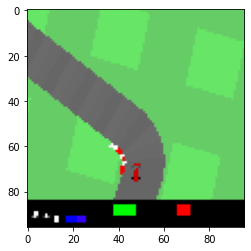

In [ ]:
# NO NEED TO MODIFY THIS CELL
# Dependencies for rendering openai gym in colab and enable video recording.
# Remove " > /dev/null 2>&1" to see what is going on under the hood
# !pip install gym[box2d] pyvirtualdisplay piglet > /dev/null 2>&1
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.* piglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers import Monitor
import tensorflow as tf
import numpy as np
import random, math, glob, io, base64
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  """
  Utility functions to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  return Monitor(env, './video', force=True)

# Download example data for training.
import gzip, os, pickle, random
import matplotlib.pyplot as plt
!gdown --id 1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0 # File shared on Peter's gdrive 6MB.
with gzip.open('carracing_behavior.gzip', 'rb') as f:
    states, action_classes = pickle.load(f)

print('\nState data shape (examples, x, y, color):', states.shape)
print('Action data shape (examples, action idx):', action_classes.shape)

# Plot an example state. This is the model input.
print('\nExample state (this is the input to your neural network):')
plt.imshow(states[0, :, :, :])

# The simulator expects a length-3 array corresponding to stear, 
# accellerate, and break. But I converted the training data actions into a 
# discrete set to frame the problem as classification. This is the set of 
# possible actions. The indices in training data targets (action_classes) 
# correspond to this set of actions. Your agent's act method should
# return one of these, not an integer index.
ACTION_SPACE = [[0, 0, 0],  # no action
                [-1, 0, 0],  # left
                [-1, 0, 1],  # left+break
                [1, 0, 0],  # right
                [1, 0, 1],  # right+break
                [0, 1, 0],  # acceleration
                [0, 0, 1], ]  # break

# Create, Train, and Simulate Agent

Create your agent class below. The code provided should help get you started. Then test your agent in the racing environment.






In [ ]:
print(action_classes)
# print(states)
print(states.dtype)

[1 5 0 ... 0 0 0]
uint8


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.optimizers
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# constants
num_classes = 7
epochs = 100
input_shape = (96, 96, 3)

In [ ]:
# y_train
# convert class vectors to binary class matrices (one-hot encoding)
actions = np_utils.to_categorical(action_classes, num_classes)
print(actions.shape)

# normalize pixel values
states = states.astype('float32')
states /= 255.0
# print(states)

(11132, 7)


In [ ]:
# keras: The validation data is selected from the last samples in the x and y data provided, before shuffling
# we need to shuffle before splitting!
X_train, X_val, y_train, y_val = train_test_split(states, actions, test_size=0.3, random_state=42)

In [ ]:
# Create a class called Agent with methods 'train' and 'act'.
# Train the agent to drive. Optimize hyperparameters such as the learning rate, network architecture, etc. 
class Agent(Sequential):

    """
    Initialize a convolutional neural network with learning rate, lr, and early stopping. 

    Args:
        pairs: int, the number convolution-subsambling pairs
        filters: tuple, the feature maps
        dense: int, the number of dense units
        dropout: float, the dropout rate
        lr: float, the learning rate
        batch_size: int, the batch size
    Returns:
        None
    """
    def __init__(self, pairs, filters, dense, dropout, lr, batch_size):
        # subclass Sequential
        # Simple fully-connected neural network with 2 hidden layers.
        super().__init__() 

        # try 2x Conv2D w/ smaller kernel
        for p in range(pairs):
            if p == 0: 
                self.add(Conv2D(filters[p], kernel_size=(5, 5), activation='relu', 
                                kernel_initializer='he_uniform', 
                                input_shape=input_shape))
                # self.add(Conv2D(filters[p], kernel_size=(3, 3), activation='relu', 
                #                 kernel_initializer='he_uniform', 
                #                 input_shape=input_shape))
                # self.add(Conv2D(filters[p], kernel_size=(3, 3), activation='relu', 
                #                 kernel_initializer='he_uniform'))

                self.add(MaxPooling2D(pool_size=(2, 2), strides=2))
            else:
                self.add(Conv2D(filters[p], kernel_size=(5, 5), activation='relu', 
                                kernel_initializer='he_uniform'))
                # self.add(Conv2D(filters[p], kernel_size=(3, 3), activation='relu', 
                #                 kernel_initializer='he_uniform'))
                # self.add(Conv2D(filters[p], kernel_size=(3, 3), activation='relu', 
                #                 kernel_initializer='he_uniform'))

                self.add(MaxPooling2D(pool_size=(2, 2), strides=2))

        self.add(Flatten())
        self.add(Dense(dense, activation='relu', kernel_initializer='he_uniform'))
        if dropout is not None:
            self.add(Dropout(dropout))
        self.add(Dense(num_classes, activation='softmax'))

        # compile the model for training
        self.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=lr), # the LR
                     metrics=['accuracy'])
        
        # stop training when val_loss stops decreasing
        # the default: monitor="val_loss", min_delta=0, patience=0
        self.callback = EarlyStopping(patience=8, mode='min', restore_best_weights=True)

        self.batch_size = batch_size

    """
    Train the model for 100 epochs max. 

    Args: 
        X: numpy array, the train inputs
        y: numpy array, the train outputs
    Returns: 
        History: the history object
    """
    def train(self, X, y): 
        return self.fit(X, y,
                        batch_size=self.batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_val, y_val),
                        callbacks=[self.callback]) # early stopping

    """
    Make prediction on input X.

    Args: 
        X: numpy array, the train input
    Returns:
        y_pred: length-3 array, the predicted action
    """
    def act(self, X):
        # normalize input pixels
        X = X.astype('float32')
        X /= 255.0

        y = self.predict(np.expand_dims(X, axis=0), # keras expects shape (None, 96, 96, 3) 
                         batch_size=self.batch_size,
                        #  verbose=1)
                         )
        idx = np.argmax(y)
        return ACTION_SPACE[idx]

In [ ]:
# tune num convolution-subsambling pairs
# search space: [1, 2, 3, 4] pairs with increasing feature maps (16, 32, 64, 128)
# constants: dense=128, dropout=None, lr=0.001, batch_size=128
history_1 = []

agent = Agent(1, (16, ), 128, None, 0.001, 128)
agent.summary()
history_1.append( agent.train(X_train, y_train) )

agent = Agent(2, (16, 32), 128, None, 0.001, 128)
agent.summary()
history_1.append( agent.train(X_train, y_train) )

agent = Agent(3, (16, 32, 64), 128, None, 0.001, 128)
agent.summary()
history_1.append( agent.train(X_train, y_train) )

agent = Agent(4, (16, 32, 64, 128), 128, None, 0.001, 128)
agent.summary()
history_1.append( agent.train(X_train, y_train) )

In [ ]:
styles = [':','-.','--','-',':','-.','--','-',':','-.','--','-']

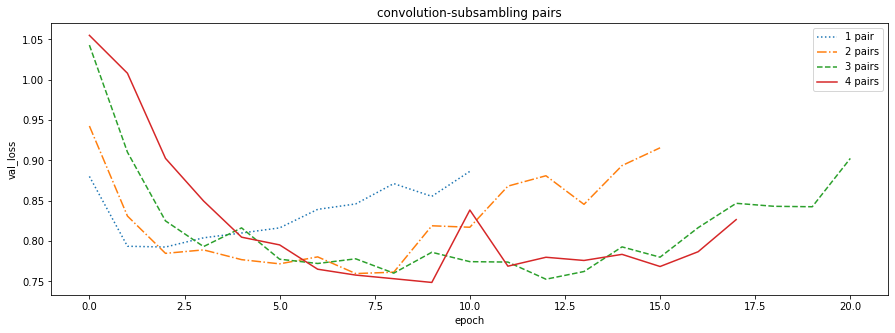

In [ ]:
names = ['1 pair', '2 pairs', '3 pairs', '4 pairs']

plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(history_1[i].history['val_loss'], linestyle=styles[i])
plt.title('convolution-subsambling pairs')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(names, loc='upper right')
plt.show()

# best=3 pairs

In [ ]:
# tune feature maps
# search space: [(8, 16, 32), (16, 32, 64), (32, 64, 128)]
# constants: pairs=3, dense=128, dropout=None, lr=0.001, batch_size=128
history_2 = []
filters = [(8, 16, 32), (16, 32, 64), (32, 64, 128)]

for i in range(3):
    agent = Agent(3, filters[i], 128, None, 0.001, 128)
    agent.summary()
    history_2.append( agent.train(X_train, y_train) )

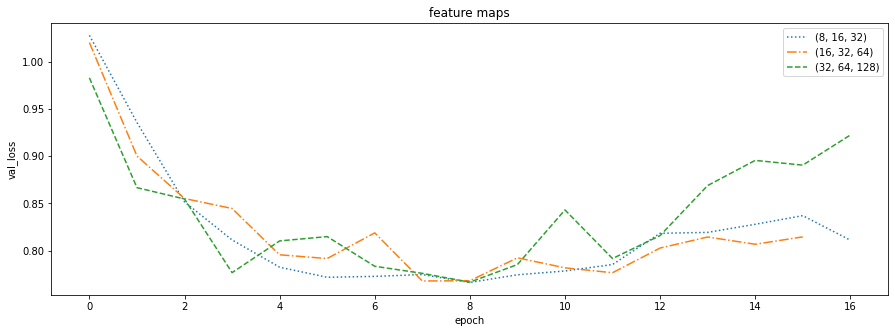

In [ ]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(history_2[i].history['val_loss'], linestyle=styles[i])
plt.title('feature maps')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(filters, loc='upper right')
plt.show()

# best=(8, 16, 32)

In [ ]:
# tune dense layer units
# search space: [128, 256, 512, 1024]
# constants: pairs=3, filters=(8, 16, 32), dropout=None, lr=0.001, batch_size=128
history_3 = []
units = [128, 256, 512, 1024]

for i in range(4):
    agent = Agent(3, (8, 16, 32), units[i], None, 0.001, 128)
    agent.summary()
    history_3.append( agent.train(X_train, y_train) )

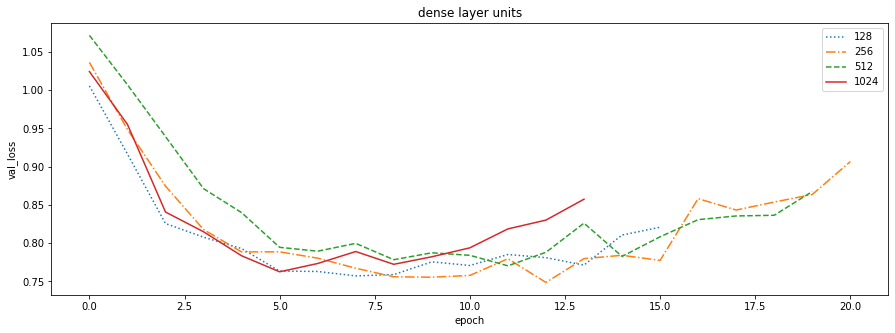

In [ ]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(history_3[i].history['val_loss'], linestyle=styles[i])
plt.title('dense layer units')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(units, loc='upper right')
plt.show()

# best=256

In [ ]:
# tune dropout rate
# search space: [None, 0.2, 0.3, 0.4]
# constants: pairs=3, filters=(8, 16, 32), dense=256, lr=0.001, batch_size=128
history_4 = []
dropout = [None, 0.2, 0.3, 0.4]

for i in range(4):
    agent = Agent(3, (8, 16, 32), 256, dropout[i], 0.001, 128)
    agent.summary()
    history_4.append( agent.train(X_train, y_train) )

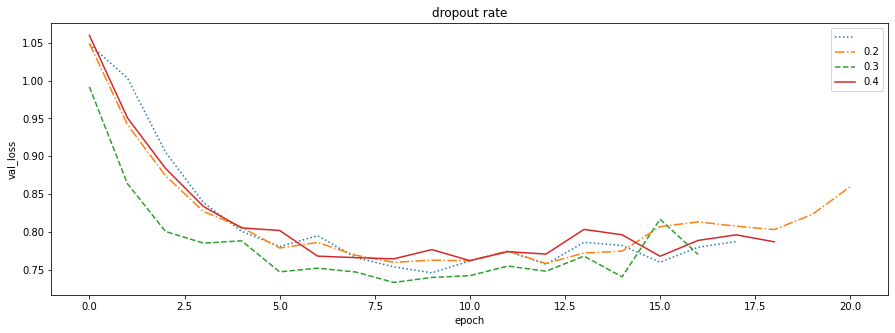

In [ ]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.plot(history_4[i].history['val_loss'], linestyle=styles[i])
plt.title('dropout rate')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(dropout, loc='upper right')
plt.show()

# best=0.3

In [ ]:
# tune learning rate
# search space: [0.01, 0.005, 0.001, 0.0005, 0.0001]
# constants: pairs=3, filters=(8, 16, 32), dense=256, dropout=0.3, batch_size=128
history_5 = []
lr = [0.01, 0.005, 0.001, 0.0005, 0.0001]

for i in range(5):
    agent = Agent(3, (8, 16, 32), 256, 0.3, lr[i], 128)
    agent.summary()
    history_5.append( agent.train(X_train, y_train) )

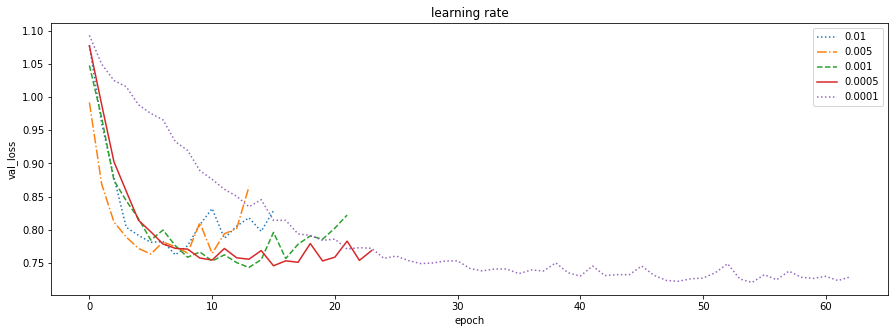

In [ ]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.plot(history_5[i].history['val_loss'], linestyle=styles[i])
plt.title('learning rate')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(lr, loc='upper right')
plt.show()

# best=0.0001

In [ ]:
# tune batch size
# search space: [32, 64, 128]
# constants: pairs=3, filters=(8, 16, 32), dense=256, dropout=0.3, lr=0.0001
history_6 = []
batch = [32, 64, 128]

for i in range(3):
    agent = Agent(3, (8, 16, 32), 256, 0.3, 0.0001, batch[i])
    agent.summary()
    history_6.append( agent.train(X_train, y_train) )

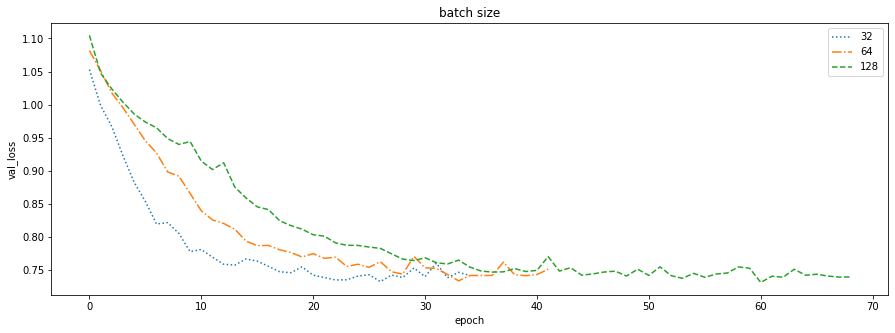

In [ ]:
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(history_6[i].history['val_loss'], linestyle=styles[i])
plt.title('batch size')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(batch, loc='upper right')
plt.show()

# best=128

In [ ]:
# retrain the best model
agent = Agent(3, (8, 16, 32), 256, 0.3, 0.0001, 128)
agent.summary()
agent.train(X_train, y_train)

# best
# Epoch 55/100
# 61/61 [==============================] - 3s 48ms/step - loss: 0.5405 - accuracy: 0.7861 - val_loss: 0.7374 - val_accuracy: 0.7168

Model: "agent_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 92, 92, 8)         608       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 16)        3216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 17, 17, 32)        12832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)         0   

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

# agent.save('saved_agent')

In [ ]:
# saved_agent = keras.models.load_model('saved_agent')

# Simulate Agent

In [ ]:
# NO NEED TO MODIFY THIS CELL
# Run simulation for t timesteps.
NUM_TIMESTEPS = 2000  # Increase this to run simulation longer.
with wrap_env(gym.make("CarRacing-v0")) as env: # Exits env when done.
  observation = env.reset()  # Restarts car at the starting line.
  for t in range(NUM_TIMESTEPS):
    env.render() 
    action = agent.act(observation)
    observation, reward, done, info = env.step(action)
    if done:
      print("Episode finished after {} timesteps".format(t+1))
      break
show_video()  # Video can be downloaded by clicking option in bottom right.

Track generation: 1181..1480 -> 299-tiles track
Episode finished after 1000 timesteps


### 1. Introduce the problem.
I am training an agent to drive on a race track from OpenAI’s CarRacing-v0 environment. The inputs of my model are (96, 96, 3) color images showing the state of the car at each timestep; the images show the position of the car, current speed, steering position, and braking status. The outputs of my model are 7 discrete actions available to the agent; the actions include steering, accelerating, and braking. 

### 2. Introduce the dataset.
The dataset is 11,132 state, action pairs. The dataset came from simulations of a highly-skilled agent. 

### 3. Introduce the model.
I am using a Convolutional Neural Network (CNN) from Keras. CNNs are especially good at image classification due to local connectivity, weight sharing, and pooling. 

### 4. Specify features and pre-processing.
1. state: 96 x 96 pixels, x 3 channels, integer, 0-255
2. action: integer, 0=no action, 1=left, 2=left+break, 3=right, 4=right+break, 
    5=acceleration, 6=break

I normalized the pixels so that each pixel has a value between 0 and 1, float. 
I one-hot encoded the actions. 

### 5. Specify data splits and how they are used. 
The total dataset contained 11,132 examples. The dataset was shuffled, then split into two subsets: 70% training, and 30% validation. The split was done using train_test_split from sklearn.model_selection. Models were trained on the training set, while the validation set was used for early stopping, hyperparameter tuning, and model selection. The test simulator was used to visually evaluate the final model. 

### 6. Specify the hyperparameters search space.
For the CNN, the range of values explored for each hyperparameter were:
1. convolution + subsampling pairs:	{ 1, 2, 3, 4 }
2. convolution filters:			[ (8, 16, 32), (16, 32, 64), (32, 64, 128) ]
3. dense layer units:			{ 128, 256, 512, 1024 }
4. dropout rate:			{ 0.0, 0.2, 0.3, 0.4 }
5. learning_rate:			{ 0.01, 0.005, 0.001, 0.0005, 0.0001 }
6. batch_size:				{ 32, 64, 128 }

I tried 4 + 3 + 4 + 4 + 5 + 3 = 23 models total. 

### 7. Explain how hyperparameters were optimized. 
Each hyperparameter was tuned independently and by hand. For each hyperparameter, the value that yielded the model with the lowest validation categorical cross entropy loss was selected as the optimal hyperparameter. The model with optimal hyperparameters was evaluated on the simulator. 

### 8. Evaluate model on clean test set.
The final model achieved a categorical cross entropy loss of 0.7374 on the validation set. The final model stayed on the randomly generated race track in the simulator. 

### 9. Explain any differences in the train/test datasets. 
The train set and validation set were shuffled before the split; there shouldn’t be any differences. There was no test set, only the simulator. 